# Experiment 3.1.2: Encoding of categorical variables

In [25]:
import math

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torcheval.metrics.functional import r2_score

from captum.attr import IntegratedGradients, Saliency, NoiseTunnel, InputXGradient, LRP, DeepLift
from captum.attr._utils.lrp_rules import EpsilonRule

#### Method to generate the categorical data samples in different encodings

In [26]:

def gen_data(values, num_features=12, num_samples=5000):
    X_label = np.random.choice(values, (num_samples, num_features))

    X = (X_label - (values - 1) / 2) / ((values - 1) / 2)

    X_one_hot = F.one_hot(torch.from_numpy(X_label)).numpy()
    

    X_dummy = X_one_hot[:, :, 0:values-1]
    
    binary_values = math.floor(np.log2(values - 1) + 1)
    X_binary = np.zeros((num_samples, num_features, binary_values))
    for i in range(len(X)):
        for j in range(len(X[0])):
            x = X_label[i, j]
            for v in range(binary_values - 1 , -1, -1):
                if x >= 2 ** v:
                    X_binary[i, j, v] = 1
                    x = x - (2 ** v)

    X_one_hot_flattend = X_one_hot.reshape(X_one_hot.shape[0], -1)

    X_dummy_flattend = X_dummy.reshape(X_dummy.shape[0], -1)

    X_binary_flattend = X_binary.reshape(X_binary.shape[0], -1)
    
    return X, X_label, X_one_hot_flattend, X_dummy_flattend, X_binary_flattend
            



#### Calculate the desired model output Y from the the X mapped to real values

In [27]:
def calc_y(X, num_samples, num_features):
    epsilon = np.random.normal(0, 1, num_samples)

    beta = np.random.uniform(-5, 5, num_features + 1)
    beta[1:] = np.ones(num_features)

    Y = beta[0] + np.sum(np.multiply(beta[1:], X), axis=1) + epsilon

    return Y, beta

#### Define the neural network

In [28]:
class Net_label(nn.Module):

    def __init__(self, num_features):
        super(Net_label, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 1)
        )

    
    def forward(self, input):
        return self.net(input)
    
class Net_encoding(nn.Module):

    def __init__(self, num_features, embedding_dim):
        super(Net_encoding, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(num_features * embedding_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 1)
        )

    
    def forward(self, input):
        return self.net(input)

#### Split the data into train and test set

In [29]:
def train_split(X, Y, num_samples, train_rate=0.80):

    index = int(num_samples * train_rate)

    X_train = X[:index]
    Y_train = Y[:index]

    X_test = X[index:]
    Y_test = Y[index:]

    return X_train, X_test, Y_train, Y_test

#### Method to train the model

In [30]:
def train_net(net, X_train, X_test, Y_train, Y_test):
    optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
    loss_fn = nn.MSELoss()

    highest_score = -10
    counter = 50
    PATH = "best_model_encoding_cat.pt"

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    Y_train_tensor = torch.tensor(Y_train.reshape(-1, 1), dtype=torch.float32)

    for epoch in range(300):
        net.train()
        optimizer.zero_grad()
        outputs = net(X_train_tensor)
        loss = loss_fn(outputs, Y_train_tensor)
        loss.backward()
        optimizer.step()

        r2 = r2_score(net.forward(torch.FloatTensor(X_test)), torch.FloatTensor(np.reshape(Y_test, (-1, 1))))

        if r2 > highest_score:
            highest_score = r2
            counter = 50
            torch.save(net.state_dict(), PATH)
        else:
            counter -= 1

        if counter == 0:
            break
    
    net.load_state_dict(torch.load(PATH, weights_only=True))
    net.eval()

    score = r2_score(net.forward(torch.from_numpy(X_test).type(torch.FloatTensor)), torch.from_numpy(np.reshape(Y_test, (-1, 1))).type(torch.FloatTensor))

    return net, score

#### Generate the attribution values

In [31]:
def calc_explanations(net, test_input_tensor, X_test):

    test_input_tensor.requires_grad_()

    #Gradient

    sal = Saliency(net)

    attr_grad = sal.attribute(test_input_tensor, abs=False)
    attr_grad = attr_grad.detach().numpy()

    #SmoothGrad

    sal = Saliency(net)
    nt = NoiseTunnel(sal)

    noise_level = 0.2
    stdev = (torch.max(test_input_tensor) - torch.min(test_input_tensor)).detach().item() * noise_level

    attr_sm_grad = nt.attribute(test_input_tensor, nt_samples=50, nt_type="smoothgrad", stdevs=stdev, abs=False)
    attr_sm_grad = attr_sm_grad.detach().numpy()

    #Saliency

    attr_sal = np.square(attr_grad)

    #InputXGradient

    ixg = InputXGradient(net)

    attr_ixg = ixg.attribute(test_input_tensor)
    attr_ixg = attr_ixg.detach().numpy()

    #LRP-Epsilon

    net.net.rule = EpsilonRule(0.1)

    lrp = LRP(net)

    attr_lrp = lrp.attribute(test_input_tensor)
    attr_lrp = attr_lrp.detach().numpy()

    #SmoothGradXInput

    ixg = InputXGradient(net)
    nt_ixg = NoiseTunnel(ixg)

    attr_sm_ixg = nt_ixg.attribute(test_input_tensor, nt_samples=50, nt_type="smoothgrad", stdevs=stdev)
    attr_sm_ixg = attr_sm_ixg.detach().numpy()

    #Integrated Gradients

    ig = IntegratedGradients(net)

    attr_ig_zero = ig.attribute(test_input_tensor,baselines=0.0)
    attr_ig_zero = attr_ig_zero.detach().numpy()
    
    
    baseline_mean = torch.mean((test_input_tensor).type(torch.FloatTensor), dim=0, keepdim=True).type(torch.FloatTensor)

    ig = IntegratedGradients(net)

    attr_ig_mean = ig.attribute(test_input_tensor,baselines=baseline_mean)
    attr_ig_mean = attr_ig_mean.detach().numpy()

    #DeepLIFT

    dl = DeepLift(net)

    attr_dl_zero = dl.attribute(test_input_tensor, baselines=0.0)
    attr_dl_zero = attr_dl_zero.detach().numpy()

    dl = DeepLift(net)

    attr_dl_mean = dl.attribute(test_input_tensor, baselines=baseline_mean)
    attr_dl_mean = attr_dl_mean.detach().numpy()

    return attr_grad, attr_sm_grad, attr_sal, attr_ixg, attr_lrp, attr_sm_ixg, attr_ig_zero, attr_ig_mean, attr_dl_zero, attr_dl_mean

#### Method to calculate the ground truth feature importances from the X mapped to real values

In [32]:
def calc_feature_importance(X_test, beta):
    feature_importance = np.multiply(beta[1:], X_test).T

    return feature_importance

#### Method to calculate the correlation between the attributions and the ground truth feature importance

In [33]:
def correlations(attr, test_input_tensor, beta, num_features, feature_importance, embedding_dim):

    if attr.shape[1] > num_features:
        for j in range(num_features):
            attr[:,j] = np.sum(attr[:, (embedding_dim*j):(embedding_dim*(j+1))], axis=1)
    attr = attr[:,:num_features]

    explainations = attr.T

    corr_matrix = np.corrcoef(feature_importance, explainations)

    corr = [corr_matrix[i, num_features + i] for i in range(num_features)]

    return corr

#### Method to print the mean and standard deviation of correlation values

In [34]:
def print_mean_std(corr, label):
    corr = np.array(corr)
    print(f"{label}: Mean = {np.nanmean(corr)}, Std = {np.nanstd(corr)}")
    return np.nanmean(corr), np.nanstd(corr)

#### Main method to run the simulation

In [35]:
num_features = 12
num_samples = 5000

methods = ["Gradient", "Smooth Grad", "Saliency", "LRP-ℇ", "GradiientxInput/LRP-0", "SmoothGradxInput", "Integrated Gradients (zero)",
                                    "Integrated Gradients (mean)", "DeepLift (zero)", "DeepLift (mean)"]

preprocessing = []

mean_vals = np.random.uniform(-1, 1, (len(methods), 8))  # mean correlation
std_vals = np.random.uniform(0.1, 0.6, (len(methods), 8))  # std deviation

j = 0


for values in [4, 12]:

    net_scores = []

    corr_grad, corr_sm_grad, corr_sal, corr_ixg, corr_lrp, corr_sm_ixg, corr_ig_zero, corr_ig_mean, corr_dl_zero, corr_dl_mean = [], [], [], [], [], [], [], [], [], []
    
    for name in ["Label", "One hot", "Dummy", "Binary"]:
        preprocessing.append(f"{values} levels, {name}")

    for i in range(200):

        X, X_label, X_one_hot, X_dummy, X_binary = gen_data(values, num_features, num_samples)

        Y, beta = calc_y(X, num_samples, num_features)

        X_train, X_test, Y_train, Y_test = train_split(X, Y, num_samples)

        feature_importance = calc_feature_importance(X_test, beta)

        # For every encoding
        for (num, x) in enumerate([X_label, X_one_hot, X_dummy, X_binary]):

            embedding_dim = int(len(x[0]) / num_features)

            if num == 0:
                net = Net_label(num_features)

            else:
                net = Net_encoding(num_features, embedding_dim)

            X_train, X_test, Y_train, Y_test = train_split(x, Y, num_samples)

            test_input_tensor = torch.from_numpy(X_test).type(torch.FloatTensor)

            net, score = train_net(net, X_train, X_test, Y_train, Y_test)

            if i == 0:
                net_scores.append([score])

            else:
                net_scores[num].append(score)

            #print(f"Net R2 Score: {score}")

            attr_grad, attr_sm_grad, attr_sal, attr_ixg, attr_lrp, attr_sm_ixg, attr_ig_zero, attr_ig_mean, attr_dl_zero, attr_dl_mean = calc_explanations(
                                                                                            net, test_input_tensor, X_test)

            for (attr, corr) in zip(
            (attr_grad, attr_sm_grad, attr_sal, attr_ixg, attr_lrp, attr_sm_ixg, attr_ig_zero, attr_ig_mean, attr_dl_zero, attr_dl_mean),
            (corr_grad, corr_sm_grad, corr_sal, corr_ixg, corr_lrp, corr_sm_ixg, corr_ig_zero, corr_ig_mean, corr_dl_zero, corr_dl_mean)
            ):
                if i == 0:
                    corr.append(correlations(attr, test_input_tensor, beta, num_features, feature_importance, embedding_dim))

                else:
                    corr[num].extend(correlations(attr, test_input_tensor, beta, num_features, feature_importance, embedding_dim))

    print(f"\n{values} Levels:")

    for (num, x) in enumerate(["Label", "One Hot", "Dummy", "Binary"]):

        print(f"\n{x} Encoding:")

        print_mean_std(net_scores[num], "Net R2 Score")
        print()

        for (i, corr, name) in zip(range(len(methods)),
                        (corr_grad, corr_sm_grad, corr_sal, corr_lrp, corr_ixg, corr_sm_ixg, corr_ig_zero, corr_ig_mean, corr_dl_zero, corr_dl_mean),
                        methods):
            
            mean, std = print_mean_std(corr[num], name)
            mean_vals[i, j] = mean
            std_vals[i, j] = std

        j += 1
    
        print()

/opt/anaconda3/lib/python3.11/site-packages/captum/log/dummy_log.py:39: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  return func(*args, **kwargs)



4 Levels:

Label Encoding:
Net R2 Score: Mean = 0.8372584581375122, Std = 0.016917891800403595

Gradient: Mean = -0.4868079446347238, Std = 0.16228172039916933
Smooth Grad: Mean = -0.5955269013033889, Std = 0.20108925765087624
Saliency: Mean = -0.5178437867142418, Std = 0.13775206786826358
LRP-ℇ: Mean = 0.8320101592825606, Std = 0.06897818403643304
GradiientxInput/LRP-0: Mean = 0.8320101083241328, Std = 0.06897820421056017
SmoothGradxInput: Mean = 0.87956484925964, Std = 0.0555359027627999
Integrated Gradients (zero): Mean = 0.9253401515191569, Std = 0.08601589716945805
Integrated Gradients (mean): Mean = 0.9911512824334958, Std = 0.0039443194841890395
DeepLift (zero): Mean = 0.9294487797566233, Std = 0.08059882927956935
DeepLift (mean): Mean = 0.9977646407989557, Std = 0.0008291086641333616


One Hot Encoding:
Net R2 Score: Mean = 0.8466017246246338, Std = 0.017397809773683548

Gradient: Mean = -0.09300878924378458, Std = 0.18872370773627853
Smooth Grad: Mean = -0.11055422466214376, 

#### Plot the results of the simulation

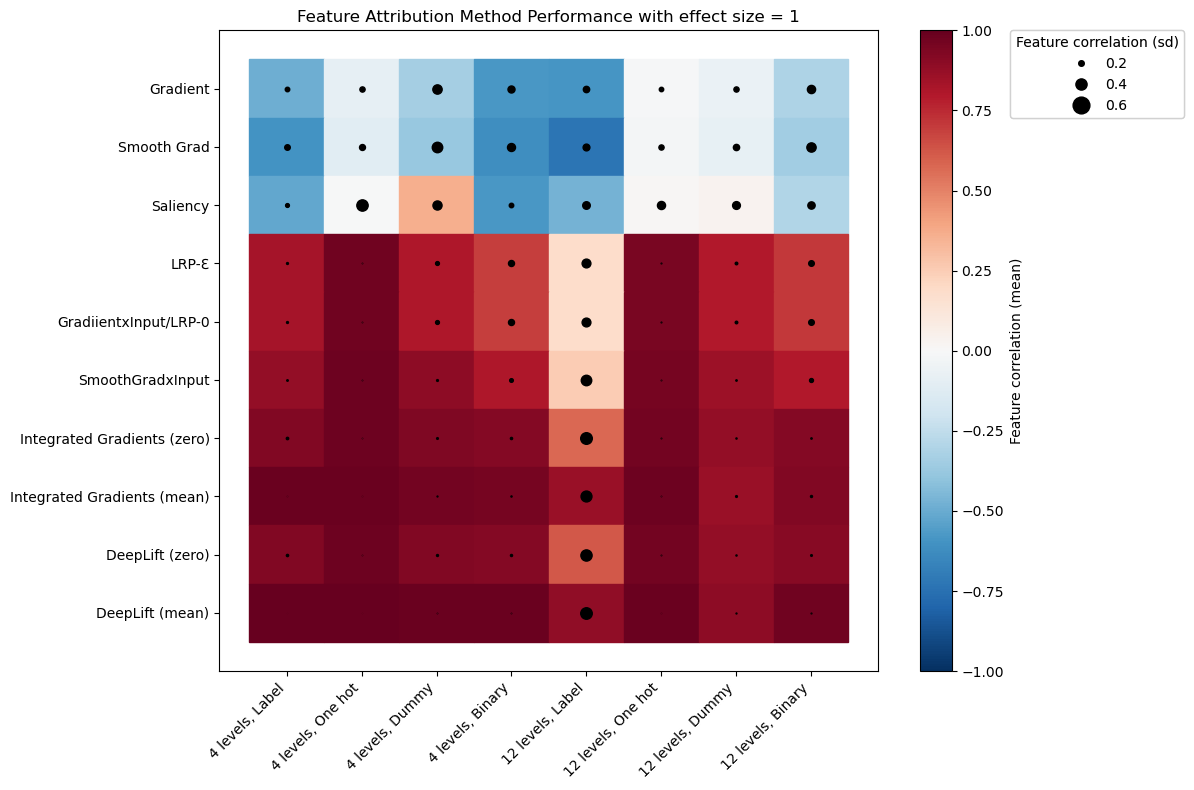

In [36]:
mean_df = pd.DataFrame(mean_vals, index=methods, columns=preprocessing)
std_df = pd.DataFrame(std_vals, index=methods, columns=preprocessing)

fig, ax = plt.subplots(figsize=(12, 8))


cmap = plt.cm.RdBu_r
norm = plt.Normalize(-1, 1)

for i, row in enumerate(mean_df.index):
    for j, col in enumerate(mean_df.columns):
        val = mean_df.loc[row, col]
        std = std_df.loc[row, col]

        ax.add_patch(plt.Rectangle((j, i), 1, 1, color=cmap(norm(val))))

        ax.plot(j + 0.5, i + 0.5, 'ko', markersize=std * 20)

ax.set_xticks(np.arange(len(mean_df.columns)) + 0.5)
ax.set_xticklabels(mean_df.columns, rotation=45, ha='right')
ax.set_yticks(np.arange(len(mean_df.index)) + 0.5)
ax.set_yticklabels(mean_df.index)
ax.invert_yaxis()

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Feature correlation (mean)')

std_legend_vals = [0.2, 0.4, 0.6]
dot_handles = [
    plt.plot([], [], 'ko', markersize=val * 20, label=f'{val:.1f}')[0]
    for val in std_legend_vals
]
std_legend = ax.legend(handles=dot_handles, title='Feature correlation (sd)',
                       loc='upper left', bbox_to_anchor=(1.2, 1), borderaxespad=0.)
fig.add_artist(std_legend)

plt.title('Feature Attribution Method Performance with effect size = 1')
plt.tight_layout()
plt.show()